## Part 1: Gathering and Cleaning Data

In [35]:
#import cell
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import seaborn as sns

In [3]:
#pipeline
def get_X_Y(offense, defense, misc):
    
    #manipulating defense col names
    defense.columns = ["Opp " + col if col not in ["Rk", "Team"] else col for col in defense.columns]
    
    #making a merged df
    misc = misc[["Team", "W", "L", "PW", "PL"]]
    merged = offense.merge(defense, on="Team").merge(misc, on="Team")
    
    #adding neccessary cols
    merged["eFG%"] = (merged["FG"] + 0.5*merged["3P"]) / merged["FGA"]
    merged["Opp eFG%"] = (merged["Opp FG"] + 0.5*merged["Opp 3P"]) / merged["Opp FGA"]
    merged["TOV%"] = merged["TOV"] / (merged["FGA"] + (0.44 * merged["FTA"]) + merged["TOV"])
    merged["Opp TOV%"] = merged["Opp TOV"] / (merged["Opp FGA"] + (0.44 * merged["Opp FTA"]) + merged["Opp TOV"])
    merged["ORB%"] = merged["ORB"] / (merged["ORB"] + merged["Opp DRB"])
    merged["DRB%"] = merged["DRB"] / (merged["DRB"] + merged["Opp ORB"])
    merged["FT STAT"] = merged["FT"] / merged["FGA"]
    merged["Opp FT STAT"] = merged["Opp FT"] / merged["Opp FGA"]
    
    #creating the 4 factor table
    four_factor = merged[["Team", "W", "L", "eFG%", "Opp eFG%", "TOV%", "Opp TOV%", "ORB%", "DRB%", 
                      "FT STAT", "Opp FT STAT"]].iloc[0:30, :]
    
    #getting X and Y

    X = four_factor[["eFG%", "Opp eFG%", "TOV%", "Opp TOV%", "ORB%", "DRB%", 
                      "FT STAT", "Opp FT STAT"]]
    
    X_standard = (X - X.mean()) / X.std()

    Y = four_factor["W"]
    
    return (X_standard,Y)

In [4]:
#reading in csvs
offense_17_18 = pd.read_csv("Offense 17-18.csv")
defense_17_18 = pd.read_csv("Defense 17-18.csv")
misc_17_18 = pd.read_csv("Misc 17-18.csv", header=1)

In [5]:
#building a linear predictor for wins

X_17_18, Y_17_18 = get_X_Y(offense_17_18, defense_17_18, misc_17_18)
X_all = sm.add_constant((X_17_18).values)

In [6]:
#examining our features to detect for correlation
X_17_18.corr()

,eFG%,Opp eFG%,TOV%,Opp TOV%,ORB%,DRB%,FT STAT,Opp FT STAT
eFG%,1.000000,-0.314328,0.152732,0.027106,-0.066095,-0.148146,0.371148,-0.237004
Opp eFG%,-0.314328,1.000000,-0.278350,0.151864,-0.150506,-0.163041,-0.036880,-0.192043
TOV%,0.152732,-0.278350,1.000000,-0.164335,0.047749,-0.348914,-0.067200,0.416009
Opp TOV%,0.027106,0.151864,-0.164335,1.000000,0.189992,-0.126070,0.000144,0.083423
ORB%,-0.066095,-0.150506,0.047749,0.189992,1.000000,-0.065879,0.176773,0.109426
DRB%,-0.148146,-0.163041,-0.348914,-0.126070,-0.065879,1.000000,-0.015526,-0.294829
FT STAT,0.371148,-0.036880,-0.067200,0.000144,0.176773,-0.015526,1.000000,-0.023534
Opp FT STAT,-0.237004,-0.192043,0.416009,0.083423,0.109426,-0.294829,-0.023534,1.000000


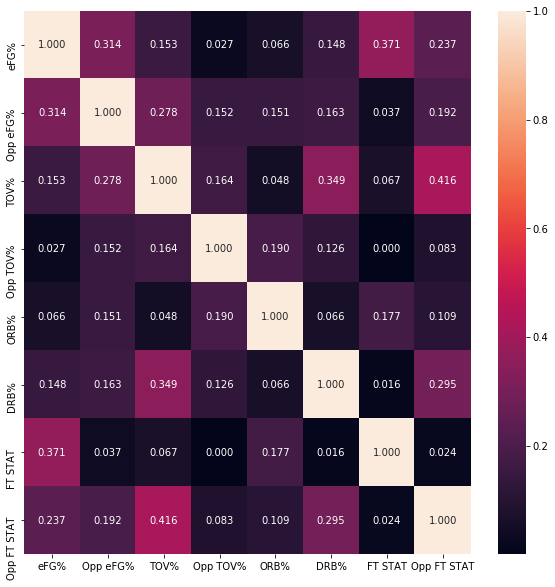

In [7]:
#a heatmap of correlation
corr = X_17_18.corr().abs()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, fmt='.3f',annot=True)
plt.show();

None of the correlations are too high, with a highest value of 0.416 between TOV% and Opp FT STAT, so the model looks good to go! The assumptions are reasonably satisfied and the covariates aren't too correlated. So, we can fit our OLS model and examine the results. 

# Part 2: Linear Regression

In [8]:
#fitting our lm and reading output
lm = sm.OLS(Y_17_18, X_all)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     31.17
Date:                Fri, 05 Jun 2020   Prob (F-statistic):           5.79e-10
Time:                        15:53:03   Log-Likelihood:                -78.830
No. Observations:                  30   AIC:                             175.7
Df Residuals:                      21   BIC:                             188.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.0000      0.731     56.098      0.000      39.480      42.520
x1             8.1115      1.032      7.862      0.000       5.966      10.257
x2            -4.6720      0.948     -4.929      0.000      -6.643      -2.701
x3            -2.9696      0.936     -3.171      0.005      -4.917      -1.022
x4             2.1405      0.815      2.627      0.016       0.446       3.835
x5             2.7003      0.815      3.315      0.003       1.006       4.394
x6             1.7665      0.905      1.952      0.064      -0.115       3.648
x7             0.9680      0.860      1.126      0.273      -0.820       2.756
x8            -1.1076      0.975     -1.136      0.269      -3.136       0.921
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.115
Skew:                          -0.132   Prob(JB):                        0.944
Kurtosis:                       2.850   Cond. No.                         2.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our condition number is pretty low, which further indicates low correlation between variables. Our model also seems to be really accurate - the R-squared value is 0.922. The last three factors all contain 0 in their 95% Confidence Interval, and the p-values are above the significance cutoff, but still fairly low. So there isn't much evidence to disregard their use as featues, and they are likely meaningful and somewhat significant in predicting wins. 

In [9]:
#obtaining our predictions and residuals
params = np.asarray(results.params).reshape(9,1)
Y_17_18_df = pd.DataFrame(Y_17_18)
Y_17_18_df["Predicted"] = X_all @ params
Y_17_18_df["Residuals"] = Y_17_18_df["W"] - Y_17_18_df["Predicted"]

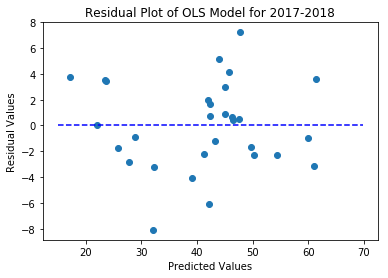

In [10]:
#making our residual plot
plt.scatter(Y_17_18_df["Predicted"], Y_17_18_df["Residuals"])
t = np.arange(15, 70, 0.2)
plt.plot(t, np.zeros(len(t)), "b--")
plt.xlabel("Predicted Values")
plt.ylabel("Residual Values")
plt.title("Residual Plot of OLS Model for 2017-2018")
plt.show()

Our residual plot looks good - there is no clear trend anywhere and it seems to be gathered around the y=0 line, so our model seems to be pretty accurate. Given these model diagnostics, let's see how this model predicts the 2018-2019 season results!

In [11]:
#initalizing our sklearn 2017-2018 model
model = LinearRegression(fit_intercept=True)
model.fit(X_17_18, Y_17_18)

LinearRegression()

In [12]:
offense_18_19 = pd.read_csv("Offense 18-19.csv")
defense_18_19 = pd.read_csv("Defense 18-19.csv")
misc_18_19 = pd.read_csv("Misc 18-19.csv", header=1)

In [13]:
#obtaining 2018-2019 data
X_18_19, Y_18_19 = get_X_Y(offense_18_19, defense_18_19, misc_18_19)

In [14]:
#our model's score while predicting 2018-2019 outcomes
model.score(X_18_19, Y_18_19)

0.92647007662243552

This is a really high R-squared value, in fact even higher than the 2017-2018 data that we trained our model on! It both demonstrates the strength and consistency of our model, and how universal Dean Oliver's 4 factors are in predicting team success from season to season.

In [15]:
new_params = np.abs(params.reshape(9,)[1:])

shooting = (new_params[0] + new_params[1]) / sum(new_params)
turnovers = (new_params[2] + new_params[3]) / sum(new_params)
rebounding = (new_params[4] + new_params[5]) / sum(new_params)
freethrows = (new_params[6] + new_params[7]) / sum(new_params)

In [16]:
print("Shooting: " + "{:.1%}".format(shooting))
print("Turnovers: " + "{:.1%}".format(turnovers))
print("Rebounding: " + "{:.1%}".format(rebounding))
print("Freethrows: " + "{:.1%}".format(freethrows))

Shooting: 52.3%
Turnovers: 20.9%
Rebounding: 18.3%
Freethrows: 8.5%


These seem to be different than Dean Oliver's weights! His were 40/25/20/15, and our analysis obtains 52/20/19/9, which perhaps can be rounded to 50/20/20/10 for simplicity and ease of interpretability. Shooting seems to be even more important than what Dean Oliver suggests, whereas turnovers and freethrows seem to be slightly less significant in predicting the number of wins. 

## Part 3: Permutation Importance

Now, we will use Sklearn's Permutation Importance Method to estimate the weights of our factors, using our linear regression model. For any given feature, this algorithm works by shuffling the values of that column randomly and examines how this change affects the predictive performance of the model. For more impactful or meaningful features, randomly shuffling them should cause greater impacts on our model accuracy. Let's try running it on our model by running 10 iterations, collecting the mean importance of each feature of each iteration, and then finding the sample mean to estimate the true importance. 

In [17]:
shooting_list = []
turnovers_list = []
rebounding_list = []
freethrows_list = []
for i in range(100):
    imp = permutation_importance(model, X_17_18, Y_17_18)
    means = imp["importances_mean"]
    shooting_list.append(means[0] + means[1])
    turnovers_list.append(means[2] + means[3])
    rebounding_list.append(means[4] + means[5])
    freethrows_list.append(means[6] + means[7])

shooting_imp = np.mean(shooting_list)
turnovers_imp = np.mean(turnovers_list)
rebounding_imp = np.mean(rebounding_list)
freethrows_imp = np.mean(freethrows_list)

imp_arr = np.array([[shooting_imp, turnovers_imp, rebounding_imp, freethrows_imp]])
imp_arr_norm = preprocessing.normalize(imp_arr, norm="l1")[0]

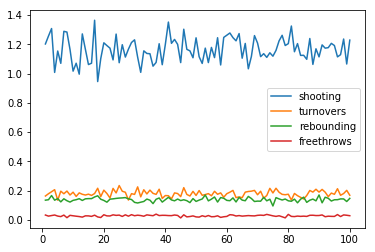

In [18]:
#plotting our estimated importances
x = np.linspace(1, 100, 100)
plt.plot(x, shooting_list, label="shooting")
plt.plot(x, turnovers_list, label="turnovers")
plt.plot(x, rebounding_list, label="rebounding")
plt.plot(x, freethrows_list, label="freethrows")
plt.legend()
plt.show()

In [19]:
#our obtained importances
print("Shooting: " + "{:.1%}".format(imp_arr_norm[0]))
print("Turnovers: " + "{:.1%}".format(imp_arr_norm[1]))
print("Rebounding: " + "{:.1%}".format(imp_arr_norm[2]))
print("Freethrows: " + "{:.1%}".format(imp_arr_norm[3]))

Shooting: 77.0%
Turnovers: 12.0%
Rebounding: 9.2%
Freethrows: 1.9%


Running this analysis to get feature importances, we see that shooting is extremely important, much more so than all of the other factors put together. However, one explanation for this possibly skewed result is that shooting overall seems to be more correlated with other factors. 

In [30]:
shooting_corr = sum(list(X_17_18.corr().abs()[["eFG%", "Opp eFG%"]].sum()))
turnovers_corr = sum(list(X_17_18.corr().abs()[["TOV%", "Opp TOV%"]].sum()))
rebounding_corr = sum(list(X_17_18.corr().abs()[["ORB%", "DRB%"]].sum()))
freethrows_corr = sum(list(X_17_18.corr().abs()[["FT STAT", "Opp FT STAT"]].sum()))

In [34]:
#correlations by factor
print("Shooting: " + "{:.3}".format(shooting_corr))
print("Turnovers: " + "{:.3}".format(turnovers_corr))
print("Rebounding: " + "{:.3}".format(rebounding_corr))
print("Freethrows: " + "{:.3}".format(freethrows_corr))

Shooting: 4.6
Turnovers: 4.22
Rebounding: 3.97
Freethrows: 4.05


If we add up the correlations, the shooting factor seems to be the highest by some distance, meaning that by this heuristic it is perhaps the most correlated with other factors. So, even if we pick another feature and randomly shuffle it, we have a lot of information encoded in the shooting columns as well; but if we shuffle the shooting column, then our model loses a lot of information and thus performs comparatively worse. Therefore, given this discrepancy in correlation, perhaps this method is not the best to use. Our earlier linear regression seems more robust to this because it doesn't weight any coefficient too heavily.

## Part 4: Conclusion

Therefore, in conclusion, we stick to our weights derived from our linear regression analysis - 

Shooting: 50%

Turnovers: 20%

Rebounding: 20%

Freethrows: 10%